##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/yamnet"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/yamnet.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/yamnet.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">   在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/yamnet.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
  <td><a href="https://tfhub.dev/google/yamnet/1"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

# 使用 YAMNet 进行声音分类

YAMNet 是一个深度网络，可以从训练它的 [AudioSet-YouTube 语料库](http://g.co/audioset)中预测 521 个音频事件[类](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv)。它采用 [Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) 深度可分离卷积架构。

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

2022-12-14 22:56:48.327474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:56:48.327582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:56:48.327593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


从 TensorFlow Hub 加载模型。

注：要阅读文档，只需点击模型的[网址](https://tfhub.dev/google/yamnet/1)

In [3]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

标签文件将从模型素材资源中加载，并位于 `model.class_map_path()` 中。您需要将其加载到 `class_names` 变量上。

In [4]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

添加一种方法来验证和转换加载的音频是否使用了正确的 sample_rate (16K)，采样率不正确会影响模型的结果。

In [5]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

## 下载并准备声音文件

在这里，您将下载一个 wav 文件并聆听。如果您已有文件，则只需将其上传到 Colab 并改用它。

注：预期的音频文件应为 16kHz 采样率的单声道 wav 文件。

In [6]:
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0  11.5M      0 --:--:-- --:--:-- --:--:-- 12.5M


In [7]:
!curl -O https://storage.googleapis.com/audioset/miaow_16k.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  210k  100  210k    0     0  14.6M      0 --:--:-- --:--:-- --:--:-- 14.6M


In [8]:
# wav_file_name = 'speech_whistling2.wav'
wav_file_name = 'miaow_16k.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 6.73s
Size of the input: 107698


/tmpfs/tmp/ipykernel_123518/2211628228.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')


需要将 `wav_data` 归一化为 `[-1.0, 1.0]` 中的值（如模型[文档](https://tfhub.dev/google/yamnet/1)中所述）。

In [9]:
waveform = wav_data / tf.int16.max

## 执行模型

现在是简单的部分：使用已经准备好的数据，只需调用模型并获取得分、嵌入向量和声谱图。

得分是您将使用的主要结果。以后将使用声谱图进行一些可视化。

In [10]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [11]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Animal


## 可视化

YAMNet 还会返回一些可用于可视化的附加信息。我们看一下波形、声谱图和推断的热门类。

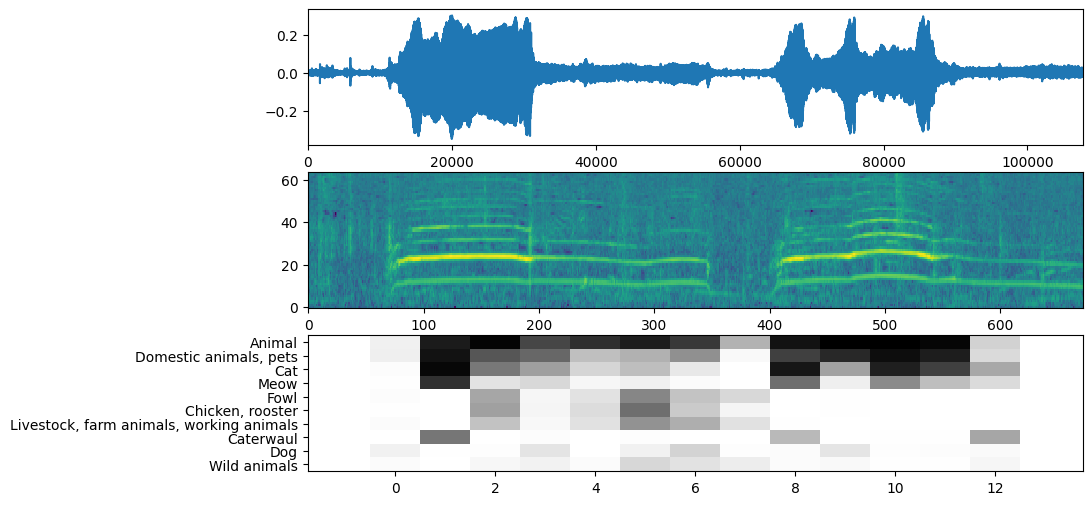

In [12]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))